In [10]:
import re
import math
import glob
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
import freud
from matplotlib import collections, colors, transforms

In [11]:
def get_checkpoints(dir):
    filelist = glob.glob(dir+"/positions_*.bin")
    g = lambda x: x.split("_")[-1].split(".")[0]
    checkpoints = [ int(g(l)) for l in filelist]
    checkpoints.sort(reverse = True)
    return checkpoints
    


def get_state():
    pos = np.fromfile(dir+"/{}_{}.bin".format('positions', cp))
    #pos = np.reshape(pos, (-1,3))
    #print(pos)
    #print(np.shape(pos))

    orient = np.fromfile(dir+"/{}_{}.bin".format('orientations', cp))
    orient = np.reshape(orient, (-1,5))[:,4]
    #print(np.shape(orient))

    box = np.fromfile(dir+"/{}_{}.bin".format('Box', cp))
    #box_xy = box[3:5]
    #print(box_xy)
    
    N_particles = len(orient)
    return N_particles, np.reshape(pos, (-1,3)), orient, box[3:5]
    

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta) 
    R = np.array(((c, -s), (s, c)))

    return R
    
def get_orient(v, rot_mat):
    return rot_mat.dot(v)

def get_triangle_vertices_i(pos_i, orient_i):
    vertices = np.zeros((3,3))

    l2 = 0.5
    h2_small = np.sqrt(3)/6
    h2_large = 2*h2_small

    rotmat_i = rotation_matrix(orient_i)
    ax0 = np.array([[-l2, l2, 0], [-h2_small, -h2_small, h2_large]])

    ax_n = get_orient(ax0, rotmat_i).T

    vertices[0,0:2] = pos_i[0:2] + ax_n[0]
    vertices[1,0:2] = pos_i[0:2] + ax_n[1]
    vertices[2,0:2] = pos_i[0:2] + ax_n[2]

    return vertices

def get_number_of_patches(type):
    if(type=="6patch"):
        #six_patch
        return 6
    elif(type=="3asym"):
        #three_asymm
        return 3
    elif(type=="vo"):
        #veritce_opposite
        return 2
    elif(type=="vn"):
        #vertice_neighbour
        return 2
    elif(type=="2asym_c"):
        #two_asymm_center
        return 3
    elif(type=="mouse"):
        #mouse
        return 3
    else:
        print("Type not defined in function get_number_of_patches. Returned 0.")
        return 0

def get_patch_pos_i(vertices_i, type, delta):
    if(type=="6patch"):
        #six_patch
        patch_pos = np.zeros((6,3))
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta
        patch_pos[1] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * (1 - delta)
        patch_pos[2] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta
        patch_pos[3] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * (1 - delta)
        patch_pos[4] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta
        patch_pos[5] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * (1 - delta)

    elif(type=="3asym"):
        #three_asymm
        patch_pos = np.zeros((3,3))
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta
        patch_pos[2] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta

    elif(type=="vo"):
        #veritce_opposite
        patch_pos = np.zeros((2,3))
        patch_pos[0] = vertices_i[0]
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta


    elif(type=="vn"):
        #vertice_neighbour
        patch_pos = np.zeros((2,3))
        patch_pos[0] = vertices_i[0]
        patch_pos[1] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta


    elif(type=="2asym_c"):
        #two_asymm_center
        patch_pos = np.zeros((3,2))
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * 0.5
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta
        patch_pos[2] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta

    elif(type=="mouse"):
        #mouse
        patch_pos = np.zeros((3,2))
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * (1 - delta)
        patch_pos[2] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta
    else:
        print("Type not defined in function get_patch_pos_i. Returned 0.")
        return 0
    return patch_pos

def get_vertices_patches():
    vertices = np.zeros((N_particles,3,3))
    patches = np.zeros((N_particles,N_patches_i,3))
    for i in range(N_particles):
        vertices[i] = get_triangle_vertices_i(pos[i], orient[i])
        patches[i] = get_patch_pos_i(vertices[i], param[0], float(param[1][0]))
    return vertices, patches

def calc_Steinhardt(num_neighbours, box, pos):
    ql = freud.order.Steinhardt(num_neighbours,average=True)
    ql = ql.compute((box,pos), neighbors={"num_neighbors": num_neighbours}).particle_order
    mean_ql= np.mean(ql)
    return mean_ql


####old voronoi
#vor = Voronoi(pos[:,0:2])
#fig = voronoi_plot_2d(vor)
#figsize = (10,10)
#plt.show()
#plt.savefig("python_voronoi_cells")
#print(cp)

#def calculate_oop(ptype, orientations):
#    #orientation order parameter
#    order_rot_sym = {"6patch" : 3,
#                "3asym" : 3,
#                "2asym_c" : 1,
#                "mouse" : 1,
#                "vo" :1,
#                "vn" :1}
#    return np.mean(np.cos(orientations*order_rot_sym[ptype]*np.pi))
#    #return mean(cospi.(order_rot_sym[ptype]* orientations))
#

#oris = np.array([0,0.5,1,1.5])
#print(calculate_oop("mouse", oris))


def voronoi_plot_deprecated(box, polytopes, volumes, volume_cutoff, ax=None):

    # Draw Voronoi polytopes
    patches = [Polygon(poly[:, :2]) for poly in polytopes]
    patch_collection = PatchCollection(patches, edgecolors="black", alpha=0.4, linewidth=0.5)
    
    colors = volumes
    num_colors = np.unique(colors).size

    bounds = [0.,volume_cutoff, 1.]
    cmap = matplotlib.colors.ListedColormap(['r', 'k'])
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    patch_collection.set_array(np.array(colors))
    patch_collection.set_cmap(cmap)
    patch_collection.set_norm(norm)
    patch_collection.set_clim(bounds[0], bounds[-1])
    ax.add_collection(patch_collection)

    # Draw box
    corners = [[0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 0, 0]]
    # Need to copy the last point so that the box is closed.
    corners.append(corners[0])
    corners = box.make_absolute(corners)[:, :2]
    ax.plot(corners[:, 0], corners[:, 1], color="k", alpha=0.2)

    # Set title, limits, aspect
    ax.set_title("Voronoi Diagram - Cell Volume Analysis")
    ax.set_aspect("equal", "datalim")

    #add colorbar
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="10%")
    cb = Colorbar(cax, patch_collection)
    cb.set_label("Polytope size")
    cb.set_ticks([0,volume_cutoff, 1])
    cb.set_ticklabels([f"<{volume_cutoff}", volume_cutoff, f">{volume_cutoff}"])
    return ax



In [32]:
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Polygon, Circle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def voronoi_plot(box, polytopes, idx_centers, idx_pores, idx_undefined, ax=None):

    # Draw Voronoi polytopes
    patches_centers = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_centers]
    patch_collection_centers = PatchCollection(patches_centers, edgecolors="black", facecolor='Red', alpha=0.4, linewidth=0.5)
    patches_pores = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_pores]
    patch_collection_pores = PatchCollection(patches_pores, edgecolors="black", facecolor='Green', alpha=0.4, linewidth=0.5)
    patches_undefined = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_undefined]
    patch_collection_undefined = PatchCollection(patches_undefined, edgecolors="black", facecolor='Gray',alpha=0.4, linewidth=0.5)
    
    #patch_collection_centers.set_color('Red')
    #patch_collection_pores.set_color('Green')
    #patch_collection_undefined.set_color('Gray')
    ax.add_collection(patch_collection_centers)
    ax.add_collection(patch_collection_pores)
    ax.add_collection(patch_collection_undefined)

    # Draw box
    corners = [[0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 0, 0]]
    # Need to copy the last point so that the box is closed.
    corners.append(corners[0])
    corners = box.make_absolute(corners)[:, :2]
    ax.plot(corners[:, 0], corners[:, 1], color="k", alpha=0.2)

    # Set title, limits, aspect
    ax.set_title("Voronoi Diagram - Cell Volume Analysis")
    ax.set_aspect("equal", "datalim")

    #add colorbar
    #ax_divider = make_axes_locatable(ax)
    #cax = ax_divider.append_axes("right", size="7%", pad="10%")
    #cb = Colorbar(cax, patch_collection)
    #cb.set_label("Polytope size")
    #cb.set_ticks([0,volume_cutoff, 1])
    #cb.set_ticklabels([f"<{volume_cutoff}", volume_cutoff, f">{volume_cutoff}"])
    return ax

def draw_polygons(vertices, ax=None):
    polygons = [Polygon(vert[:,:2]) for vert in vertices]
    polyong_collection = PatchCollection(polygons, edgecolors="black", facecolor='Blue', alpha=0.7, linewidth=0.01)
    ax.add_collection(polyong_collection)
    return ax


def draw_patches(patch_pos, ax=None):
    patches = [Circle(patch, radius=0.05) for patch in np.reshape(patch_pos, (-1,3))]
    patches_collection = PatchCollection(patches, edgecolors="black", facecolor='black', alpha=0.7, linewidth=0.01)
    ax.add_collection(patches_collection)
    return ax

def draw_voroplot(filename = None, SAVE = True, DPI=1000, DRAW_POLYGONS = True, DRAW_PATCHES = True):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    if DRAW_POLYGONS:
        vertices_voro = vertices - box_length/2
        draw_polygons(vertices_voro,ax)
    if DRAW_PATCHES:
        patches_voro  = patches - box_length/2
        draw_patches(patches_voro,ax)
    voronoi_plot(freud_box, voro.polytopes, idx_centers, idx_pores, idx_undefined,ax=ax)
    #nx.draw(G,pos=posdict,with_labels=False, font_weight='bold')
    if SAVE:
        plt.savefig(filename, dpi=DPI)
    plt.show()
    return None



../../../runs_varT_test/3asym/3asym_d0.35_r0.05_mu0.2_phi0.25_T0.145_eps-1_id1/


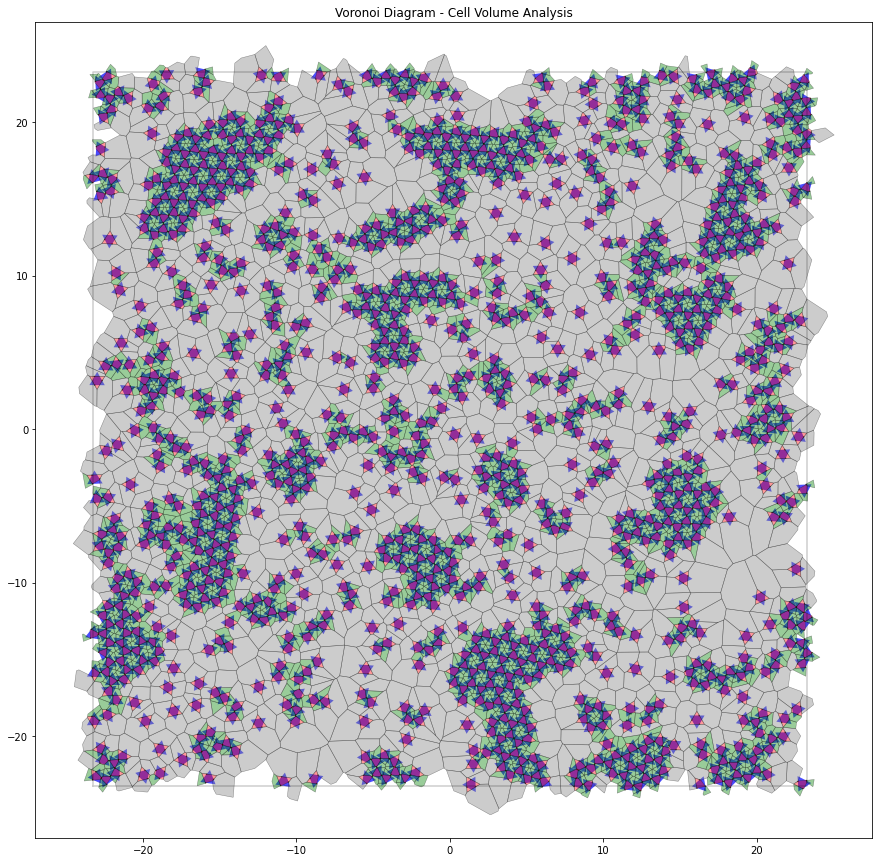

In [31]:
def get_param_from_dir(dir):
    subdir = dir.split("/",5)[-1]
    ptype, paramstring = subdir.split("_",1)
    return ptype, re.findall(r"[-+]?\d*\.\d+|\d+\d?", paramstring)

path = "../../../runs_varT_test/3asym/*/"
#path = "runs/mouse/*/"
dirlist = glob.glob(path)
for dir in dirlist:
    param = get_param_from_dir(dir)
    if param[1] != ['0.35', '0.05', '0.2', '0.25', '0.145', '1', '1']: #d r mu phi T eps id
        continue
    print(dir)
    N_patches_i = get_number_of_patches(param[0])
    checkpoints = get_checkpoints(dir)

    for icp, cp in enumerate(checkpoints[1:2]):

        N_particles, pos, orient, box_xy = get_state()
        box_length = box_xy[0]

        vertices, patches = get_vertices_patches()

        #######calc voronoi
        freud_box = freud.box.Box.square(box_length)
        voroplot_center = pos
        voroplot_center[:,:2]-= box_length/2
        voroplot_center[:,2]=0
    
        points = np.copy(np.reshape(vertices,(N_particles*3,3)))
        points[:,:2]-=box_length/2
        points = np.append(points,voroplot_center,axis=0)
        voro = freud.locality.Voronoi()
        voro.compute((freud_box, points))
        
        volume_cutoff = 0.44
        idx_centers = np.arange(len(points)-len(pos),len(points))
        idx_pores = [idx for idx, vol in enumerate(voro.volumes[:-len(pos)]) if vol <= volume_cutoff]
        idx_undefined = [idx for idx in range(len(points)) if ((idx not in idx_centers) and (idx not in idx_pores))]
        
        neighbours = voro.nlist

        draw_voroplot(filename="../../../python_voronoi_plot.jpeg", SAVE = True, DRAW_POLYGONS = True, DRAW_PATCHES = True)

        ######calculate clusters

In [18]:
import networkx as nx

posdict = {}
for i,pos in enumerate(points[:,:2]):
    posdict[i]=pos

filt = np.array(len(neighbours))
print(filt)
for i,neigh in enumerate(neighbours):
    if (neigh[0] in idx_centers) or (neigh in idx_centers):
        filt[i]=True

#G = nx.Graph()
#G.add_edges_from(neighbours)
#plt.figure(figsize=(100,100))
#nx.draw(G,pos=posdict,with_labels=False, font_weight='bold')

#print(G.nodes)

NameError: name 'points' is not defined

In [ ]:
Gr = nx.Graph()
#G.add_nodes_from(points[:,:2])
print(points[:,:2])

[[ 21.76763073  21.08389688]
 [ 21.63226824  22.07469302]
 [ 20.84189485  21.4620676 ]
 ...
 [-22.07933925  20.81160307]
 [ 10.20463177 -15.91577694]
 [ 15.51936388  -3.82904087]]
